# BERTScore Scoring Against NIST and Wikipedia

Duplicating CrisisFACTS 2022 assessment via BERTScore

In [100]:
%matplotlib inline

In [101]:
import pandas as pd
import numpy as np
import json
import glob
import gzip
import torch

import scipy.stats

import matplotlib.pyplot as plt

In [102]:
import wikipedia

In [103]:
from torchmetrics.text.rouge import ROUGEScore

## Get CrisisFACTS Event Metadata

In [104]:
event_df = pd.read_json("CrisisFACTs-2022to2023.topics.json", lines=False).set_index("eventID")

### Get Summaries from Wikipedia

In [105]:
def get_wiki_summary(url):
    
    if "wikipedia.org" not in url:
        return ""
    
    page_title = url.rpartition("/")[-1]
    print(url)
    page = wikipedia.page(title=page_title, auto_suggest=False)
    
    return page.summary

event_df["wiki.summary"] = event_df["url"].apply(get_wiki_summary)

https://en.wikipedia.org/wiki/Lilac_Fire
https://en.wikipedia.org/wiki/Cranston_Fire
https://en.wikipedia.org/wiki/Holy_Fire_(2018)
https://en.wikipedia.org/wiki/Hurricane_Florence
https://en.wikipedia.org/wiki/2018_Maryland_flood
https://en.wikipedia.org/wiki/Saddleridge_Fire
https://en.wikipedia.org/wiki/Hurricane_Laura
https://en.wikipedia.org/wiki/Hurricane_Sally
https://en.wikipedia.org/wiki/2020_Beirut_explosion
https://en.wikipedia.org/wiki/2020_Houston_explosion
https://en.wikipedia.org/wiki/Edenville_Dam#Dam_failure
https://en.wikipedia.org/wiki/Hurricane_Dorian
https://en.wikipedia.org/wiki/Kincade_Fire
https://en.wikipedia.org/wiki/2020_Easter_tornado_outbreak
https://en.wikipedia.org/wiki/Tornado_outbreak_of_April_22-23,_2020
https://en.wikipedia.org/wiki/Tornado_outbreak_of_March_2-3,_2020


### Get Summaries from Assessors

In [106]:
with open("final-annotated-facts-results.json", "r") as in_file:
    annotation_data = json.load(in_file)

In [107]:
event_fact_lists = {}

for req_id,req_data in annotation_data.items():
    event_id = req_id.rpartition("-")[0]
    local_fact_set = {f[0] for f in req_data["fact_list"] if f[2] == "USEFUL_FACT"}
    
    with open("../00-createSummaries/collapsed-event-days/Collapsed-%s.json" % req_id) as in_file:
        local_fact_data = json.load(in_file)
        
    local_fact_text = [
        fact["fact_text"] for fact in local_fact_data 
        if fact["collapsed_fact_id"] in local_fact_set
    ]
    
    local_fact_list = event_fact_lists.get(event_id, [])
    local_fact_list = local_fact_list + local_fact_text
    event_fact_lists[event_id] = local_fact_list

In [108]:
event_df["nist.summary"] = [". ".join(event_fact_lists[event_id]).replace("..", ".") for event_id in event_df.index]


In [109]:
# print the nist summary for event 001 and save it to a file
event_df["nist.summary"].iloc[0]

'Wind gusts have been recorded at 40-50 mph in the area. The PIO (public information officer) will be located at Hwy 76 & Old Hwy 395. Evacuation orders are in effect for the #LilacFire. Old River Road at Little Gopher Canyon Road through Golf Club Drive is closed. : Evacuation Centers. The California Thoroughbred Horsemen\'s Foundation is assisting those impacted by the fire. Trees and poles are deeply charred or still smoking. Shelters opened for evacuees and pets. Firefighters are needed at TC West Lilac at 395. All #CoastNewsClassic games at Carlsbad High School have been cancelled today. Jacumba and Dulzura area, more than 1,600 customers were without power. Bonsall High School is being evacuated. Gopher Canyon Road is closed from East Vista Way to Little Gopher Canyon Road. Ojai, population 7,500, was among several cities threatened in Ventura County, where more than 400 buildings had been destroyed as of Thursday night and 85 more damaged. Fallbrook High School is open as an eva

In [110]:
# save on file and convert all to ascii on a txt
with open("nist_summary.txt", "w") as out_file:
    out_file.write(event_df["nist.summary"].iloc[0].encode("ascii", "ignore").decode("ascii"))


## Save the Summaries

In [111]:
event_df.to_json("CrisisFACTs-2022to2023.topics.withSummaries.json")

In [112]:
event_df = pd.read_json("CrisisFACTs-2022to2023.topics.withSummaries_smaller.json", lines=False)

In [113]:
# # save on file and convert all to ascii on a txt
# with open("nist_summary_2.txt", "w") as out_file:
#     out_file.write(event_df["nist.summary"].iloc[0].encode("ascii", "ignore").decode("ascii"))

In [114]:
# rouge = ROUGEScore(
#     use_stemmer=True,
# )

import bert_score
bert_score.__version__

'0.3.12'

In [115]:
TOP_K = 32

In [116]:
all_req_ids = list(annotation_data.keys())

In [117]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [118]:
# bert_model = "distilbert-base-uncased"
bert_model = "microsoft/deberta-xlarge-mnli"

In [ ]:
submission_metrics = {}

for f in glob.glob("submissions/*.gz"):
    
    this_run_id = f.partition("/")[-1].replace(".gz", "")
    print(f, "-->", this_run_id)
    
    this_run_event_request_facts = {k:[] for k in all_req_ids}
    with gzip.open(f, "r") as in_file:
        for line_ in in_file:
            line = line_.decode("utf8")
            
            entry = json.loads(line)
            this_req_id = entry["requestID"]
            
            # We skip days where we have no relevant facts from assessors
            if this_req_id not in all_req_ids:
                continue
            
            this_run_event_request_facts[this_req_id].append(entry)
            
    local_event_summaries = {e_id:[] for e_id in event_df.index}
    for event_request,this_fact_list in this_run_event_request_facts.items():
        event_id = event_request.rpartition("-")[0]
        
        sorted_fact_list = sorted(this_fact_list, key=lambda v: v["importance"], reverse=True)
        this_day_summary = [this_top_fact["factText"] for this_top_fact in sorted_fact_list[:TOP_K]]
        
        local_event_summaries[event_id] = local_event_summaries[event_id] + this_day_summary
        

    wiki_dfs = []
    nist_dfs = []
    for event_id,event in event_df.iterrows():
        
        this_submitted_summary = local_event_summaries[event_id]

        this_summary_text = ". ".join(this_submitted_summary).replace("..", ".")
        if len(this_summary_text) == 0:
            continue
        
        nist_summary = event["nist.summary"]
        wiki_summary = event["wiki.summary"]

        print(f"event {event_id} - nist: {len(nist_summary)} - submitted: {len(this_summary_text)}")
        
        nist_metric_ = bert_score.score([this_summary_text], [nist_summary], model_type=bert_model, device=device, batch_size=1, nthreads=2)
        torch.cuda.empty_cache()
        wiki_metric_ = bert_score.score([this_summary_text], [wiki_summary], model_type=bert_model, device=device, batch_size=1, nthreads=2)
        torch.cuda.empty_cache()
        
        nist_metric = {
            "f1": nist_metric_[2],
            "precision": nist_metric_[0],
            "recall": nist_metric_[1],
        }
        
        wiki_metric = {
            "f1": wiki_metric_[2],
            "precision": wiki_metric_[0],
            "recall": wiki_metric_[1],
        }
        
        this_wiki_df = pd.DataFrame([{"metric":k, "value":v.item(), "event": event_id} for k,v in wiki_metric.items()])
        this_nist_df = pd.DataFrame([{"metric":k, "value":v.item(), "event": event_id} for k,v in nist_metric.items()])
        
        display(this_nist_df)
        
        wiki_dfs.append(this_wiki_df)
        nist_dfs.append(this_nist_df)
        
    full_wiki_df = pd.concat(wiki_dfs)
    full_nist_df = pd.concat(nist_dfs)
    
    submission_metrics[this_run_id] = {
        "wiki": full_wiki_df,
        "nist": full_nist_df,
    }
    
    display(full_nist_df.groupby("metric")["value"].mean())



submissions\Thesis_Retriver.gz --> 
event CrisisFACTS-001 - nist: 19263 - submitted: 0
Skipping empty summary
event CrisisFACTS-002 - nist: 14820 - submitted: 0
Skipping empty summary
event CrisisFACTS-003 - nist: 15533 - submitted: 0
Skipping empty summary
event CrisisFACTS-004 - nist: 46829 - submitted: 0
Skipping empty summary
event CrisisFACTS-005 - nist: 7919 - submitted: 0
Skipping empty summary
event CrisisFACTS-006 - nist: 13126 - submitted: 0
Skipping empty summary
event CrisisFACTS-007 - nist: 9517 - submitted: 0
Skipping empty summary
event CrisisFACTS-008 - nist: 37230 - submitted: 0
Skipping empty summary
event CrisisFACTS-009 - nist: 23198 - submitted: 0
Skipping empty summary
event CrisisFACTS-010 - nist: 7252 - submitted: 13117


,metric,value,event
0,f1,0.762733,CrisisFACTS-010
1,precision,0.770505,CrisisFACTS-010
2,recall,0.755116,CrisisFACTS-010


event CrisisFACTS-011 - nist: 5395 - submitted: 16730


,metric,value,event
0,f1,0.722039,CrisisFACTS-011
1,precision,0.735012,CrisisFACTS-011
2,recall,0.709516,CrisisFACTS-011


event CrisisFACTS-012 - nist: 15799 - submitted: 13410


,metric,value,event
0,f1,0.888745,CrisisFACTS-012
1,precision,0.884823,CrisisFACTS-012
2,recall,0.892702,CrisisFACTS-012


event CrisisFACTS-013 - nist: 17062 - submitted: 17131


,metric,value,event
0,f1,0.896717,CrisisFACTS-013
1,precision,0.896853,CrisisFACTS-013
2,recall,0.896581,CrisisFACTS-013


event CrisisFACTS-014 - nist: 36760 - submitted: 0
Skipping empty summary
event CrisisFACTS-015 - nist: 21998 - submitted: 37637


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.93 GiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 8.48 GiB is allocated by PyTorch, and 419.55 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
all_runs = []
for k,v in submission_metrics.items():
    print(k)
    
    stackable = []
    for comparator,ldf in v.items():
        stackable_ldf = ldf.copy()
        stackable_ldf["target.summary"] = comparator

        stackable.append(stackable_ldf)

    this_run_df = pd.concat(stackable)
    this_run_df["run"] = k
    
    all_runs.append(this_run_df)
    this_run_df.to_csv("evaluation.output.bertscore/%s.csv" % k, index=False)
    
all_runs_df = pd.concat(all_runs)
all_runs_df.to_csv("evaluation.output.bertscore/all_runs.csv", index=False)

In [ ]:
target_summaries = {}
for target in ["wiki", "nist"]:
    this_target_df = all_runs_df[all_runs_df["target.summary"] == target]
    
    index = []
    rows = []
    for run_name,group in this_target_df.groupby("run"):
        print(run_name)
        # this_row = group.pivot("event", "metric", "value").mean()
        this_row = group.pivot(index="event", columns="metric", values="value").mean()
        rows.append(this_row)
        index.append(run_name)

    summary_df = pd.DataFrame(rows, index=index)[[
        "f1", 
    ]]

    final_df = summary_df.sort_values(by="f1", ascending=False)
    final_df.to_csv("evaluation.output.bertscore/%s.summary.csv" % target)
    
    target_summaries[target] = final_df

In [ ]:
rel2023_events = [
    'CrisisFACTS-009',
    'CrisisFACTS-010',
    'CrisisFACTS-011',
    'CrisisFACTS-012',
    'CrisisFACTS-013',
    'CrisisFACTS-014',
    'CrisisFACTS-015',
    'CrisisFACTS-016',
    'CrisisFACTS-017',
    'CrisisFACTS-018'

]

In [ ]:
rows = []
for runtag,group in all_runs_df[all_runs_df["event"].isin(rel2023_events)].groupby("run"):
    print(runtag)
    t_map = {"run": runtag}
    for target,t_group in group.groupby("target.summary"):
        print("\t", target)
        
        if target == "wiki":
            t_group = t_group[~t_group["event"].isin(["CrisisFACTS-011", "CrisisFACTS-012"])]
        for metric,m_group in t_group.groupby("metric"):
            print("\t\t", metric, m_group["value"].mean())
            
            t_map["%s.%s" % (target,metric)] = m_group["value"].mean()
            
    rows.append(t_map)


	 nist
		 f1 0.8119206577539444
		 precision 0.8105234801769257
		 recall 0.8134236857295036
	 wiki
		 f1 0.7466365794340769
		 precision 0.7262659172217051
		 recall 0.7687798241774241


In [ ]:
by_run_df = pd.DataFrame(rows).set_index("run")
by_run_df.to_csv("by_run.bertscore.summary.csv")
by_run_df[["nist.f1", "wiki.f1"]]

,nist.f1,wiki.f1
run,,
,0.811921,0.746637


In [ ]:
by_run_df[["nist.f1", "wiki.f1"]].corr()

,nist.f1,wiki.f1
nist.f1,NaN,NaN
wiki.f1,NaN,NaN


<Axes: xlabel='nist.f1', ylabel='wiki.f1'>

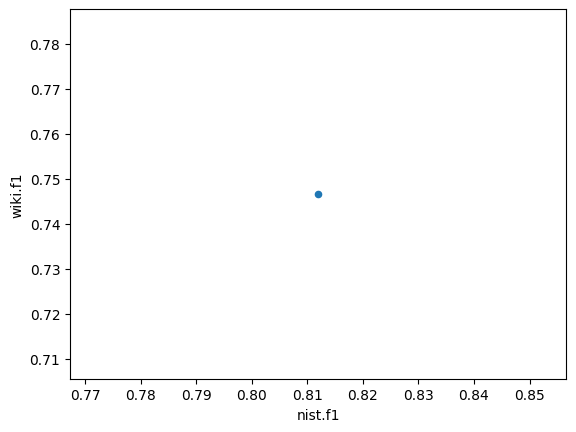

In [ ]:
by_run_df[["nist.f1", "wiki.f1"]].plot.scatter(x="nist.f1", y="wiki.f1")

<Axes: ylabel='run'>

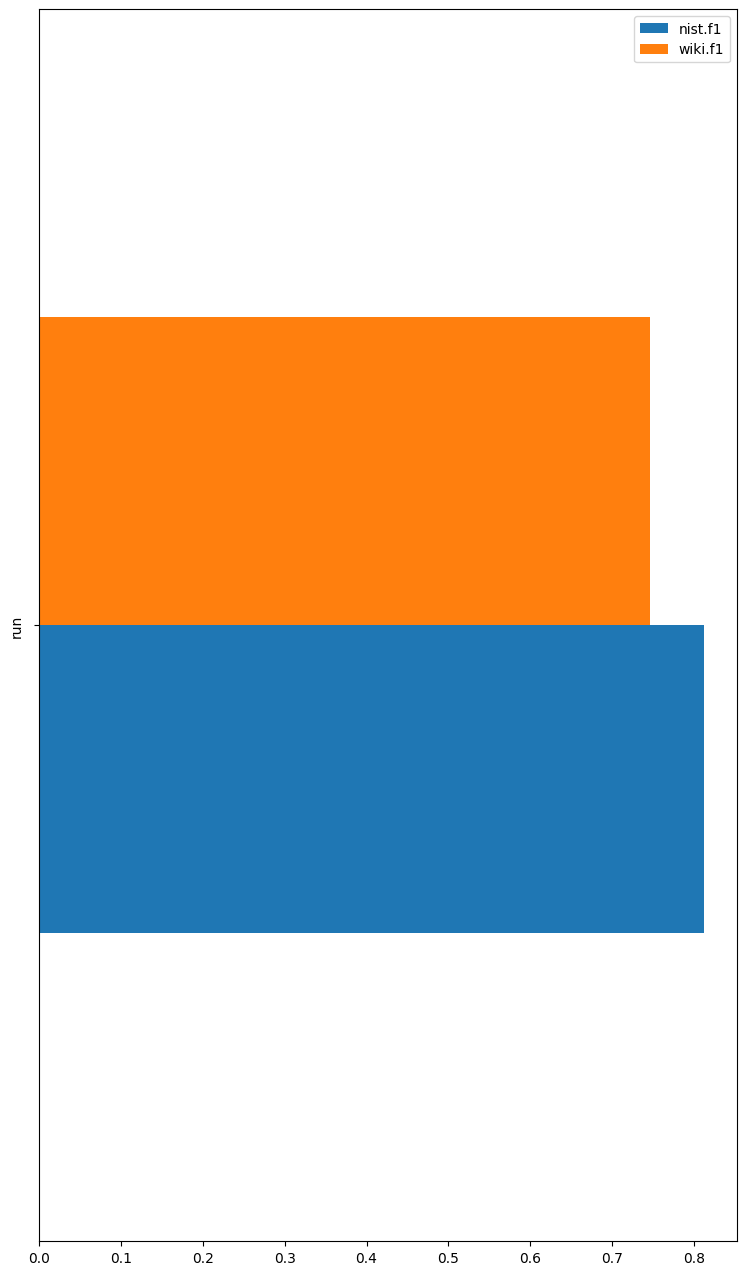

In [ ]:
fig = plt.figure(figsize=(9,16))
ax = fig.add_subplot(1,1,1)

by_run_df[["nist.f1", "wiki.f1"]].sort_values(by="nist.f1").plot.barh(ax=ax)

## By Day

In [ ]:
rows = []
for event,group in all_runs_df[all_runs_df["event"].isin(rel2023_events)].groupby("event"):
    print(event)
    t_map = {"event": event}
    for target,t_group in group.groupby("target.summary"):
        print("\t", target)
        
        if target == "wiki":
            t_group = t_group[~t_group["event"].isin(["CrisisFACTS-011", "CrisisFACTS-012"])]
        for metric,m_group in t_group.groupby("metric"):
            print("\t\t", metric, m_group["value"].mean())
            
            t_map["%s.%s" % (target,metric)] = m_group["value"].mean()
            
    rows.append(t_map)

CrisisFACTS-010
	 nist
		 f1 0.8052867650985718
		 precision 0.8006007075309753
		 recall 0.810028076171875
	 wiki
		 f1 0.7424697875976562
		 precision 0.7310268878936768
		 recall 0.754276692867279
CrisisFACTS-011
	 nist
		 f1 0.7731232643127441
		 precision 0.7658663988113403
		 recall 0.7805190086364746
	 wiki
CrisisFACTS-012
	 nist
		 f1 0.8085600137710571
		 precision 0.803749680519104
		 recall 0.8134282827377319
	 wiki
CrisisFACTS-013
	 nist
		 f1 0.7996808290481567
		 precision 0.7993745803833008
		 recall 0.7999874353408813
	 wiki
		 f1 0.7252477407455444
		 precision 0.7079290151596069
		 recall 0.7434351444244385
CrisisFACTS-015
	 nist
		 f1 0.8038163185119629
		 precision 0.8186014294624329
		 recall 0.7895557880401611
	 wiki
		 f1 0.7661961317062378
		 precision 0.7463946342468262
		 recall 0.7870768308639526
CrisisFACTS-016
	 nist
		 f1 0.8385006189346313
		 precision 0.8358165621757507
		 recall 0.8412019610404968
	 wiki
		 f1 0.7550361752510071
		 precision 0.756015479

In [ ]:
by_event_df = pd.DataFrame(rows).set_index("event")
by_event_df.to_csv("by_event.bertscore.summary.csv")
by_event_df[["nist.f1", "wiki.f1"]]

,nist.f1,wiki.f1
event,,
CrisisFACTS-010,0.805287,0.742470
CrisisFACTS-011,0.773123,NaN
CrisisFACTS-012,0.808560,NaN
CrisisFACTS-013,0.799681,0.725248
CrisisFACTS-015,0.803816,0.766196
CrisisFACTS-016,0.838501,0.755036
CrisisFACTS-017,0.834201,0.751705
CrisisFACTS-018,0.832196,0.739165


<Axes: ylabel='event'>

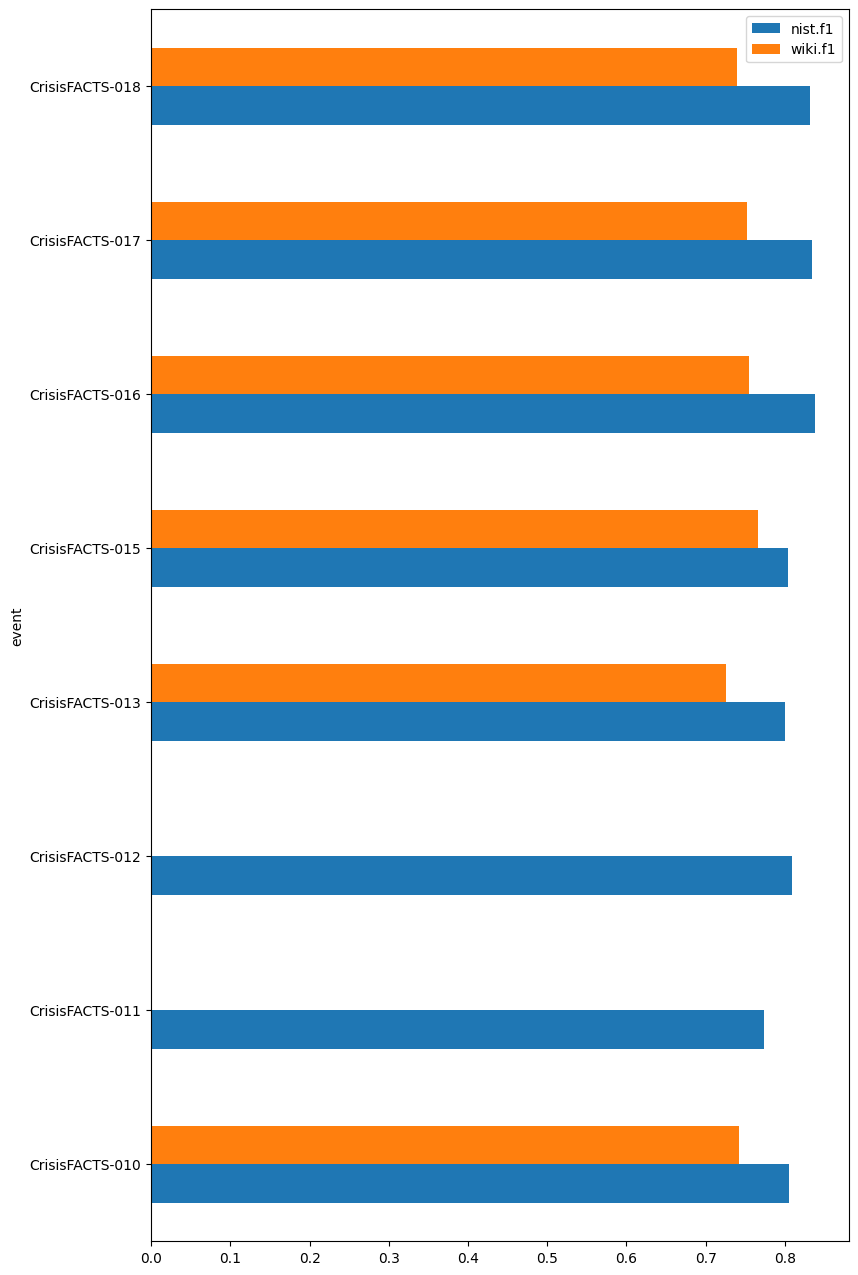

In [ ]:
fig = plt.figure(figsize=(9,16))
ax = fig.add_subplot(1,1,1)

by_event_df[["nist.f1", "wiki.f1"]].plot.barh(ax=ax)

In [ ]:
score_df = pd.read_csv("by_event.bertscore.summary.csv", index_col=0)
print(score_df.groupby("event").mean().style.to_latex())

\begin{tabular}{lrrrrrr}
 & nist.f1 & nist.precision & nist.recall & wiki.f1 & wiki.precision & wiki.recall \\
event &  &  &  &  &  &  \\
CrisisFACTS-010 & 0.805287 & 0.800601 & 0.810028 & 0.742470 & 0.731027 & 0.754277 \\
CrisisFACTS-011 & 0.773123 & 0.765866 & 0.780519 & nan & nan & nan \\
CrisisFACTS-012 & 0.808560 & 0.803750 & 0.813428 & nan & nan & nan \\
CrisisFACTS-013 & 0.799681 & 0.799375 & 0.799987 & 0.725248 & 0.707929 & 0.743435 \\
CrisisFACTS-015 & 0.803816 & 0.818601 & 0.789556 & 0.766196 & 0.746395 & 0.787077 \\
CrisisFACTS-016 & 0.838501 & 0.835817 & 0.841202 & 0.755036 & 0.756015 & 0.754059 \\
CrisisFACTS-017 & 0.834201 & 0.830016 & 0.838428 & 0.751705 & 0.712607 & 0.795342 \\
CrisisFACTS-018 & 0.832196 & 0.830162 & 0.834241 & 0.739165 & 0.703623 & 0.778489 \\
\end{tabular}



In [ ]:
print(score_df.groupby("event").mean().style.to_latex())

\begin{tabular}{lrrrrrr}
 & nist.f1 & nist.precision & nist.recall & wiki.f1 & wiki.precision & wiki.recall \\
event &  &  &  &  &  &  \\
CrisisFACTS-010 & 0.805287 & 0.800601 & 0.810028 & 0.742470 & 0.731027 & 0.754277 \\
CrisisFACTS-011 & 0.773123 & 0.765866 & 0.780519 & nan & nan & nan \\
CrisisFACTS-012 & 0.808560 & 0.803750 & 0.813428 & nan & nan & nan \\
CrisisFACTS-013 & 0.799681 & 0.799375 & 0.799987 & 0.725248 & 0.707929 & 0.743435 \\
CrisisFACTS-015 & 0.803816 & 0.818601 & 0.789556 & 0.766196 & 0.746395 & 0.787077 \\
CrisisFACTS-016 & 0.838501 & 0.835817 & 0.841202 & 0.755036 & 0.756015 & 0.754059 \\
CrisisFACTS-017 & 0.834201 & 0.830016 & 0.838428 & 0.751705 & 0.712607 & 0.795342 \\
CrisisFACTS-018 & 0.832196 & 0.830162 & 0.834241 & 0.739165 & 0.703623 & 0.778489 \\
\end{tabular}

